# Lab | Text Generation from Shakespeare's Sonnet

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
from tensorflow.keras import regularizers  # This is what you need to import
###
import tensorflow.keras.utils as ku
import numpy as np

In [3]:
import requests
# Download the Shakespeare sonnets
url = "https://folger-main-site-assets.s3.amazonaws.com/uploads/2022/11/shakespeares-sonnets_TXT_FolgerShakespeare.txt"
response = requests.get(url)
data = response.text

# Clean the data - remove header and footer
lines = data.split('\n')
start_index = None
end_index = None

for i, line in enumerate(lines):
    if line.strip() == '1':  # First sonnet starts with '1'
        start_index = i
        break

# Use only the actual sonnet content
if start_index is not None:
    corpus = lines[start_index:]
else:
    corpus = lines  # Fallback if pattern not found

# Convert to lowercase and clean
corpus = [line.lower().strip() for line in corpus if line.strip()]  # Remove empty lines

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# Create input sequences
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Create predictors and labels
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

In [5]:
from tensorflow.keras import regularizers
max_features = total_words
max_length = max_sequence_len - 1


model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=500, input_length=max_length))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(100))
model.add(Dense(100, activation='relu',
            kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(max_features, activation='softmax'))
# Pick an optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.build(input_shape=(None, max_length)) # Build the model with an appropriate input shape
print(model.summary())

2025-09-15 20:36:12.804819: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-09-15 20:36:12.804853: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-15 20:36:12.804866: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-09-15 20:36:12.804902: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-15 20:36:12.804922: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 500)           1683500   
                                                                 
 lstm (LSTM)                 (None, 11, 100)           240400    
                                                                 
 dropout (Dropout)           (None, 11, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 3367)              340067    
                                                                 
Total params: 2354467 (8.98 MB)
Trainable params: 235446

In [6]:
 history = model.fit(predictors, label, epochs=200, verbose=1)

Epoch 1/200


2025-09-15 20:36:27.298945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-09-15 20:36:27.623350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-09-15 20:36:28.007876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-09-15 20:36:28.950362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-09-15 20:36:29.438707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


490/490 [==============================] - 14s 22ms/step - loss: 7.0491 - accuracy: 0.0192
Epoch 2/200
490/490 [==============================] - 10s 20ms/step - loss: 6.5143 - accuracy: 0.0222
Epoch 3/200
490/490 [==============================] - 10s 20ms/step - loss: 6.4213 - accuracy: 0.0231
Epoch 4/200
490/490 [==============================] - 10s 20ms/step - loss: 6.3291 - accuracy: 0.0286
Epoch 5/200
490/490 [==============================] - 10s 20ms/step - loss: 6.2222 - accuracy: 0.0310
Epoch 6/200
490/490 [==============================] - 10s 20ms/step - loss: 6.1242 - accuracy: 0.0340
Epoch 7/200
490/490 [==============================] - 10s 20ms/step - loss: 6.0355 - accuracy: 0.0394
Epoch 8/200
490/490 [==============================] - 10s 20ms/step - loss: 5.9536 - accuracy: 0.0402
Epoch 9/200
490/490 [==============================] - 10s 20ms/step - loss: 5.8777 - accuracy: 0.0429
Epoch 10/200
490/490 [==============================] - 10s 20ms/step - loss: 5.8019 

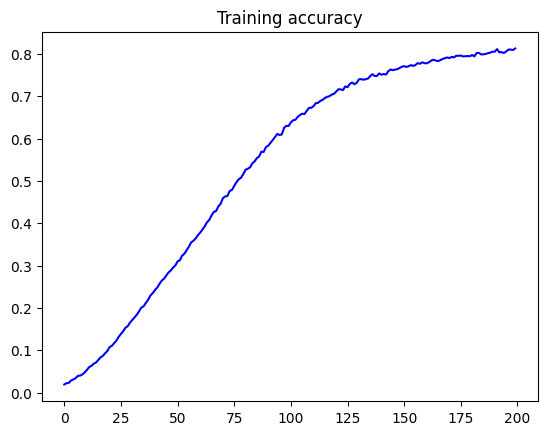

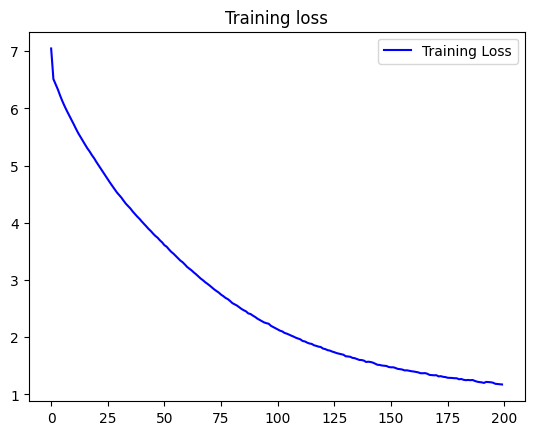

In [7]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [10]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

seed_text = seed_text.replace('\r', '') # Remove carriage return characters
seed_text

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [16]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
    # Convert text to number sequence    
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    
    # Pad to the required length    
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    
    # FIXED: Use predict() instead of predict_classes()
    # Get prediction probabilities

    predicted_probs = model.predict(token_list, verbose=0)

    # Find which word has the highest probability
    predicted = np.argmax(predicted_probs, axis=-1)
    
    # Convert number back to word
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    # Add the new word to the text       
    seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope my least days lose praise an thrivers thrivers thrivers my deep unless love's stage canker smell dressings night of weeds endeared gracious name dressings limping increase appear dressings dressings dressings dressings dressings dressings care dressings endeared dressings endeared endeared endeared thrivers thrivers thrivers thrivers thrivers printed resty overpartial endeared thrivers thrivers thee high youth becomes despair taste overpartial endeared allayed gracious barren defect skill smell growth of rhymers overpartial endeared rhymers printed endeared mind nought shape doth girded oppression printed batt'ring printed twain kind bright bath praise batt'ring thee girded girded batt'ring show rhymers girded printed such effect rhymers girded


In [17]:
# After generating the text, format it with line breaks
formatted_text = seed_text.replace('\r', '')

# Split into lines of ~8-10 words each (like a poem)
words = formatted_text.split()
lines = []
current_line = ""

for i, word in enumerate(words):
    current_line += word + " "
    # Break every 8 words, or at punctuation
    if (i + 1) % 8 == 0 or word in ['.', '?', '!', ',']:
        lines.append(current_line.strip())
        current_line = ""

# Add the last line if any words remain
if current_line:
    lines.append(current_line.strip())

# Print with line breaks
print("\n".join(lines))

Help me Obi Wan Kenobi, you're my only
hope my least days lose praise an thrivers
thrivers thrivers my deep unless love's stage canker
smell dressings night of weeds endeared gracious name
dressings limping increase appear dressings dressings dressings dressings
dressings dressings care dressings endeared dressings endeared endeared
endeared thrivers thrivers thrivers thrivers thrivers printed resty
overpartial endeared thrivers thrivers thee high youth becomes
despair taste overpartial endeared allayed gracious barren defect
skill smell growth of rhymers overpartial endeared rhymers
printed endeared mind nought shape doth girded oppression
printed batt'ring printed twain kind bright bath praise
batt'ring thee girded girded batt'ring show rhymers girded
printed such effect rhymers girded
